In [1]:
#Imports
import os
import torch
import random
import numpy as np
import pandas
import gc
import shutil
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision.io import decode_image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
if not os.path.exists("/content/resources.zip"): shutil.copy("/content/drive/MyDrive/resources.zip", "/content/")
if not os.path.exists("/content/resources"): shutil.unpack_archive("/content/resources.zip", "/content/resources")

In [3]:
#Dataset
class SkinDiseaseDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.labels_map={}
        labels_list=[]
        num=0
        for dir in os.listdir(self.img_dir):
            category=dir
            self.labels_map[num]=category
            for file in os.listdir(os.path.join(img_dir, dir)):
                labels_list.append((file, num))
            num+=1
        self.img_labels=pandas.DataFrame.from_records(labels_list)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.labels_map[self.img_labels.iloc[idx, 1]], self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
#Testing utilities
def train(model, dataset, EPOCHS, batch_size, optimizer, criterion, device, transform):
    train_dataset=SkinDiseaseDataset(os.path.join(dataset, "train"), transform=transform)
    train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataset=SkinDiseaseDataset(os.path.join(dataset, "validation"), transform=transform)
    val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Limpiar gradientes
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)  # Forward
            n_classes = outputs.shape[1]
            labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()

            loss = criterion(outputs, labels_one_hot)  # Pérdida
            loss.backward()  # Backward
            optimizer.step()  # Update

            running_loss += loss.item()

            # Accuracy en train
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / max(1, len(train_loader))
        train_acc = 100.0 * correct / max(1, total)

        # ---- Validación (loss) ----
        model.eval()
        dev_running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                n_classes = outputs.shape[1]
                labels_one_hot = F.one_hot(labels, num_classes=n_classes).float()
                dev_loss = criterion(outputs, labels_one_hot)
                dev_running_loss += dev_loss.item()
        avg_dev_loss = dev_running_loss / max(1, len(val_loader))

        # ---- Validación (accuracy) usando tu función evaluate ----
        dev_acc = evaluate(model, device, os.path.join(dataset, "validation"), batch_size, transform)[0]  # imprime y devuelve accuracy

        # Guardar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        # Log por época (conciso y claro)
        print(f'[Epoch {epoch + 1}] '
              f'train_loss: {avg_train_loss:.3f} | train_acc: {train_acc:.2f}% | '
              f'dev_loss: {avg_dev_loss:.3f} | dev_acc: {dev_acc:.2f}%')

    return model, history

def evaluate(model, device, data, BATCH_SIZE, transform):
    test_dataset=SkinDiseaseDataset(data, transform=transform)
    test_loader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    model.eval()  # Poner el modelo en modo evaluación
    correct = 0
    total = test_loader.dataset.__len__()  # Total de muestras en el conjunto de test
    all_preds = []
    all_labels = []
    with torch.no_grad():  # No calcular gradientes
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Mover datos al dispositivo
            outputs = model(inputs)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
            correct += (predicted == labels).sum().item()  # Actualizar el contador de aciertos
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = 100 * correct / total if total > 0 else 0.0
    return accuracy, cm

def plot_training_history(history):
    """
    Dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.
    Espera claves: 'train_loss', 'train_acc', 'dev_loss', 'dev_acc'.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def print_cm(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def runNN(model, DEVICE, data, epochs, BATCH_SIZE, optimizer, loss, transform):
    classes=[]
    for dir in os.listdir(os.path.join(data, "test")): classes.append(dir)
    model, history=train(model, data, epochs, BATCH_SIZE, optimizer, loss, DEVICE, transform)
    accuracy, cm=evaluate(model, DEVICE, os.path.join(data, "test"), BATCH_SIZE, transform)
    print(f"eval_acc: {accuracy:.2f}%")
    plot_training_history(history)
    print_cm(cm, classes)

[Epoch 1] train_loss: 2.337 | train_acc: 12.26% | dev_loss: 2.318 | dev_acc: 14.26%
[Epoch 2] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.318 | dev_acc: 14.26%
[Epoch 3] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.319 | dev_acc: 14.26%
[Epoch 4] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.319 | dev_acc: 14.26%
[Epoch 5] train_loss: 2.337 | train_acc: 12.38% | dev_loss: 2.318 | dev_acc: 14.26%
eval_acc: 13.04%


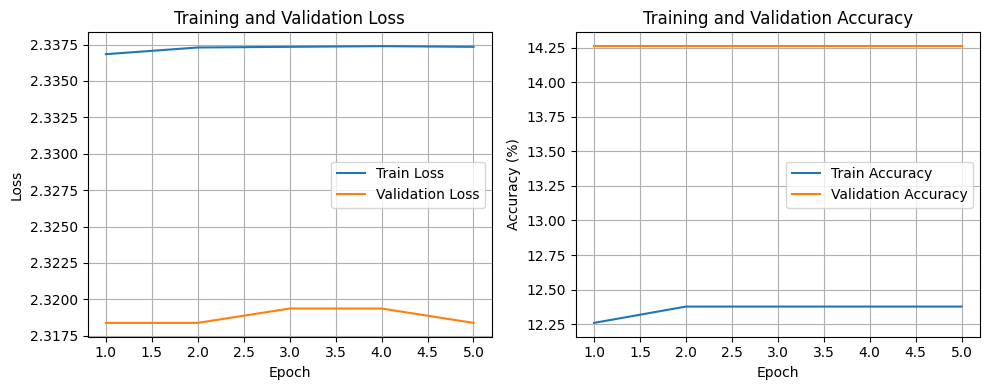

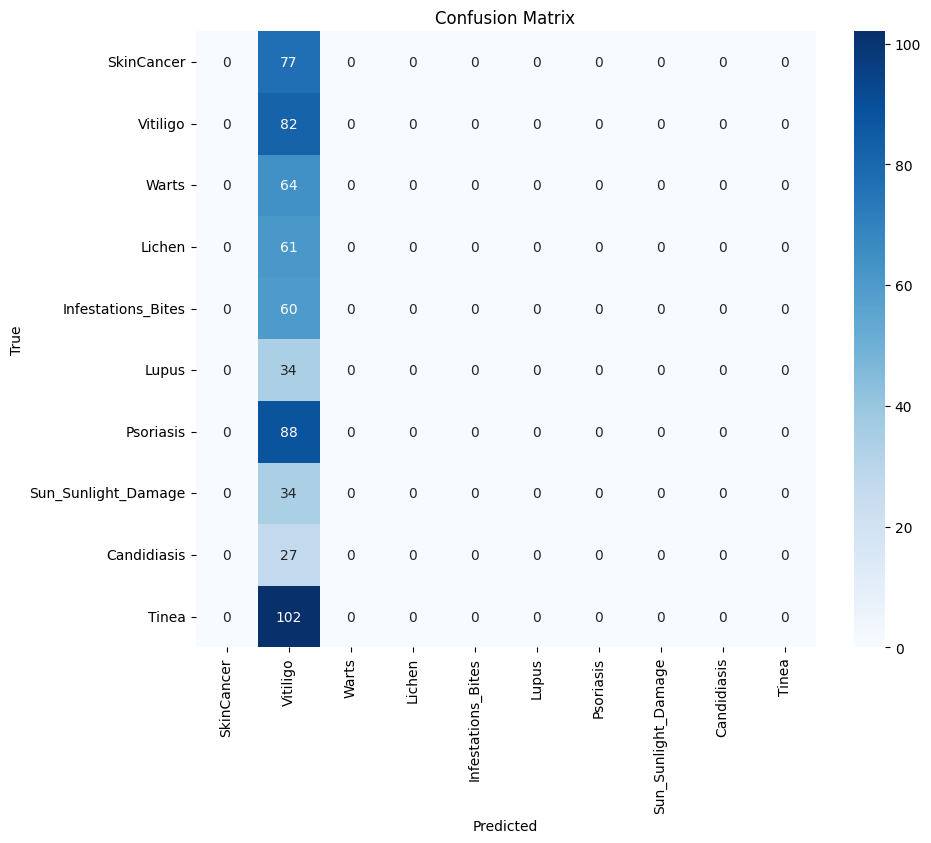

In [12]:
#Prueba no convolutiva
class SimpleNetwork(nn.Module):
    def __init__(self):
        super(SimpleNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.activation=nn.Sigmoid()
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return self.softmax(x)

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SimpleNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 32, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 215.803 | train_acc: 11.51% | dev_loss: 79.930 | dev_acc: 6.21%
[Epoch 2] train_loss: 155.609 | train_acc: 11.53% | dev_loss: 144.198 | dev_acc: 14.26%
[Epoch 3] train_loss: 160.358 | train_acc: 10.98% | dev_loss: 145.824 | dev_acc: 10.57%
[Epoch 4] train_loss: 158.125 | train_acc: 12.34% | dev_loss: 170.358 | dev_acc: 10.57%
[Epoch 5] train_loss: 153.997 | train_acc: 11.24% | dev_loss: 164.176 | dev_acc: 6.21%
eval_acc: 5.41%


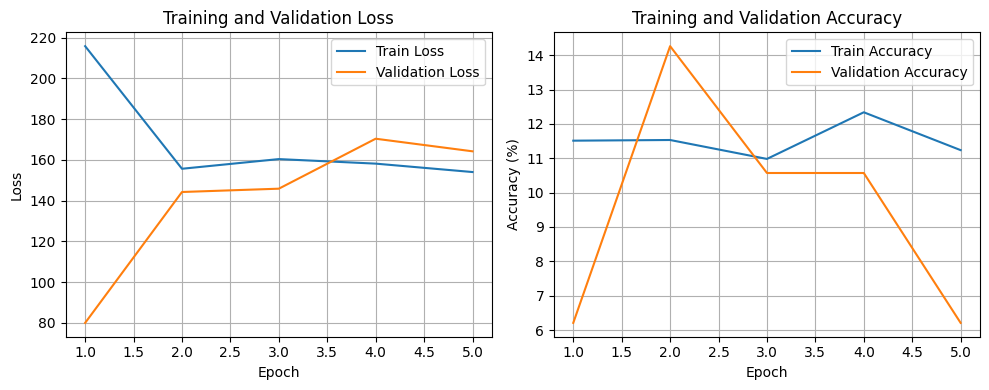

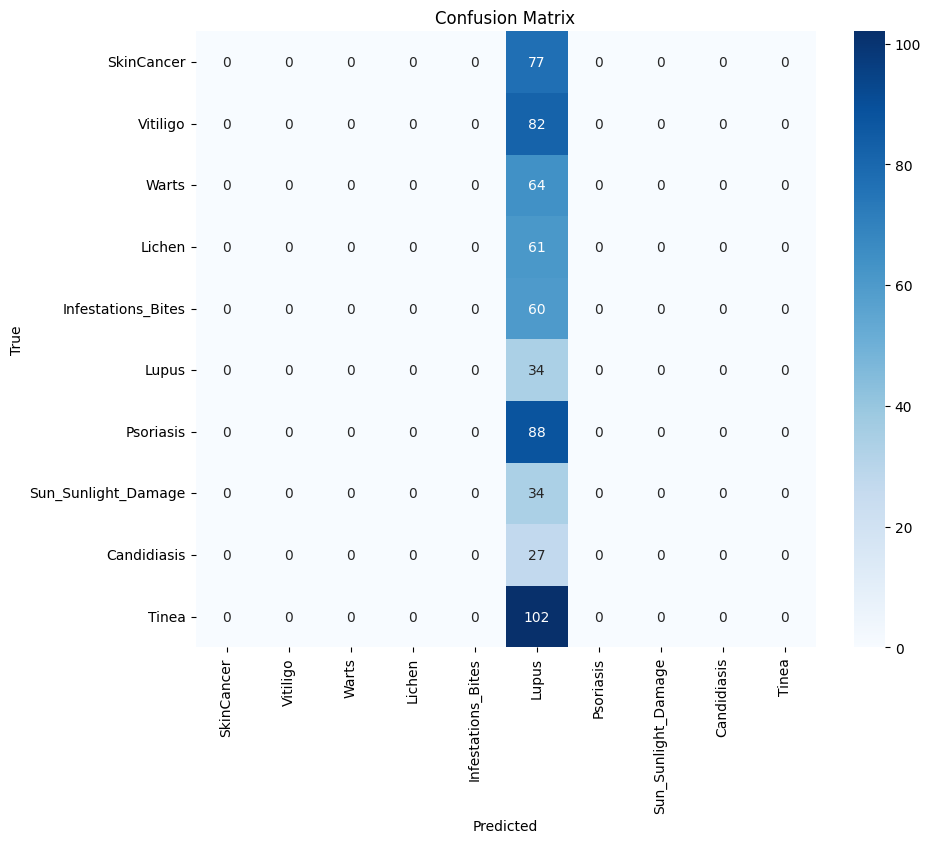

In [13]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super(ConvNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Sigmoid()

    def forward(self, x):
        x=self.pool(self.activation(self.conv1(x)))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=ConvNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 32, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 296.747 | train_acc: 11.81% | dev_loss: 185.796 | dev_acc: 11.24%
[Epoch 2] train_loss: 275.290 | train_acc: 11.90% | dev_loss: 356.440 | dev_acc: 9.56%
[Epoch 3] train_loss: 227.345 | train_acc: 11.22% | dev_loss: 228.620 | dev_acc: 6.88%
[Epoch 4] train_loss: 211.676 | train_acc: 11.92% | dev_loss: 207.916 | dev_acc: 19.30%
[Epoch 5] train_loss: 187.484 | train_acc: 12.12% | dev_loss: 118.458 | dev_acc: 10.57%
eval_acc: 10.33%


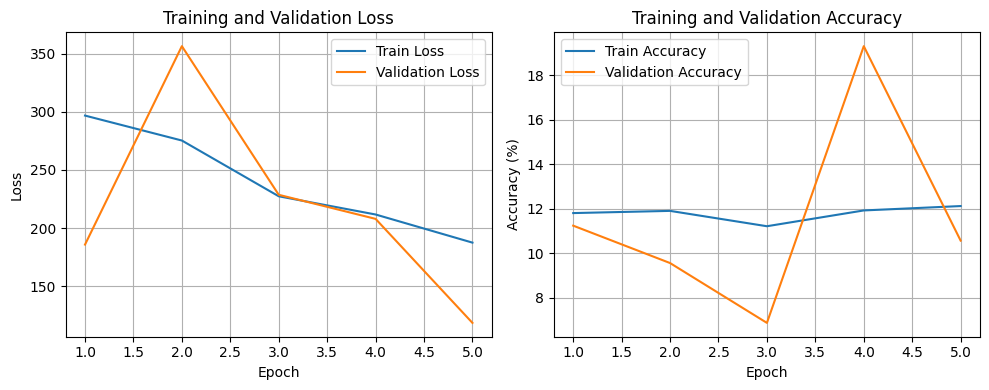

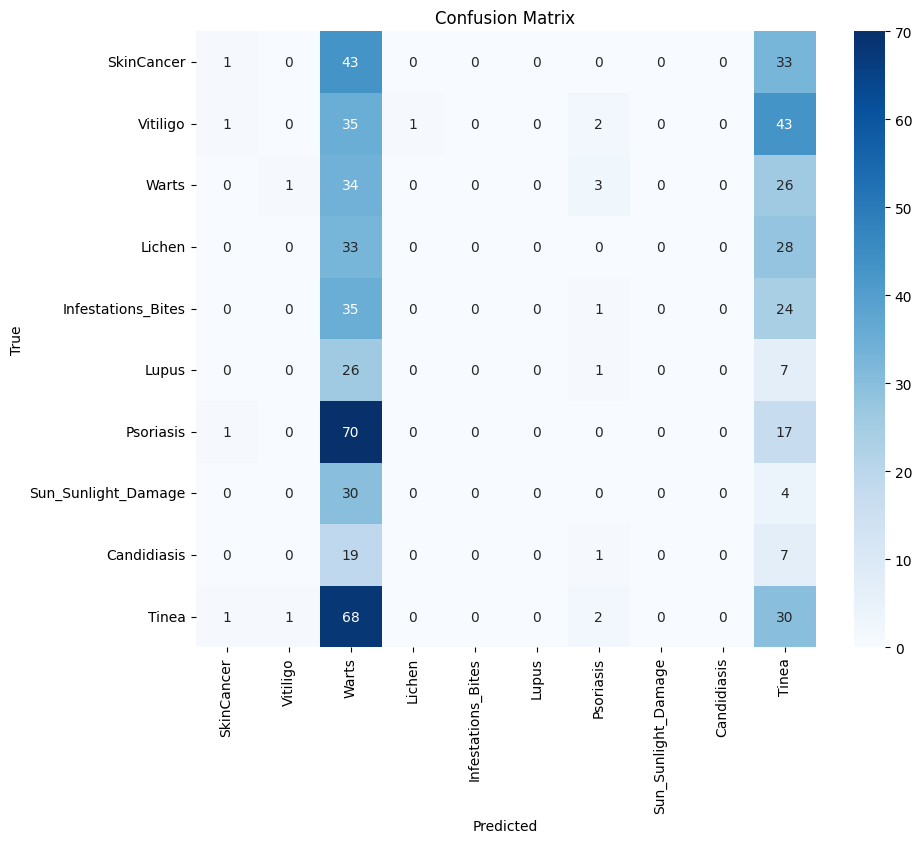

In [12]:
class TanhNetwork(nn.Module):
    def __init__(self):
        super(TanhNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.pool(self.activation(self.conv1(x)))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=TanhNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 5, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((82, 87)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 334.448 | train_acc: 11.10% | dev_loss: 433.226 | dev_acc: 13.93%
[Epoch 2] train_loss: 317.481 | train_acc: 11.12% | dev_loss: 333.948 | dev_acc: 10.57%
[Epoch 3] train_loss: 308.672 | train_acc: 11.77% | dev_loss: 257.428 | dev_acc: 14.26%
[Epoch 4] train_loss: 325.540 | train_acc: 11.26% | dev_loss: 273.848 | dev_acc: 11.07%
[Epoch 5] train_loss: 203.098 | train_acc: 11.35% | dev_loss: 259.397 | dev_acc: 8.39%
[Epoch 6] train_loss: 183.031 | train_acc: 10.61% | dev_loss: 104.783 | dev_acc: 16.95%
eval_acc: 14.47%


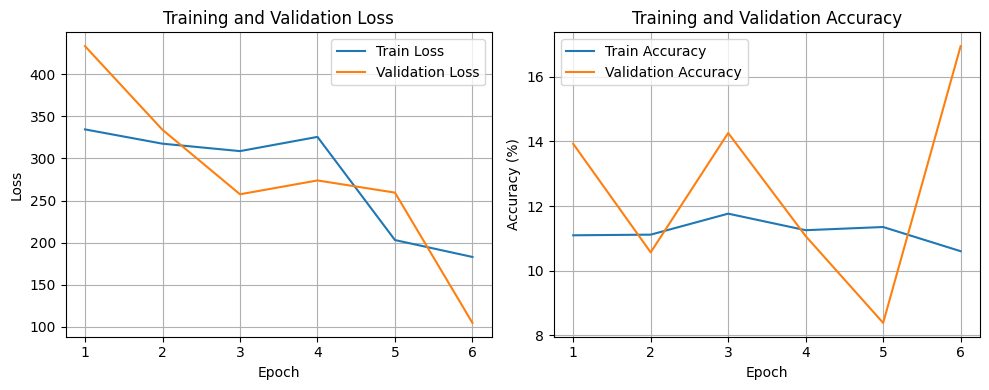

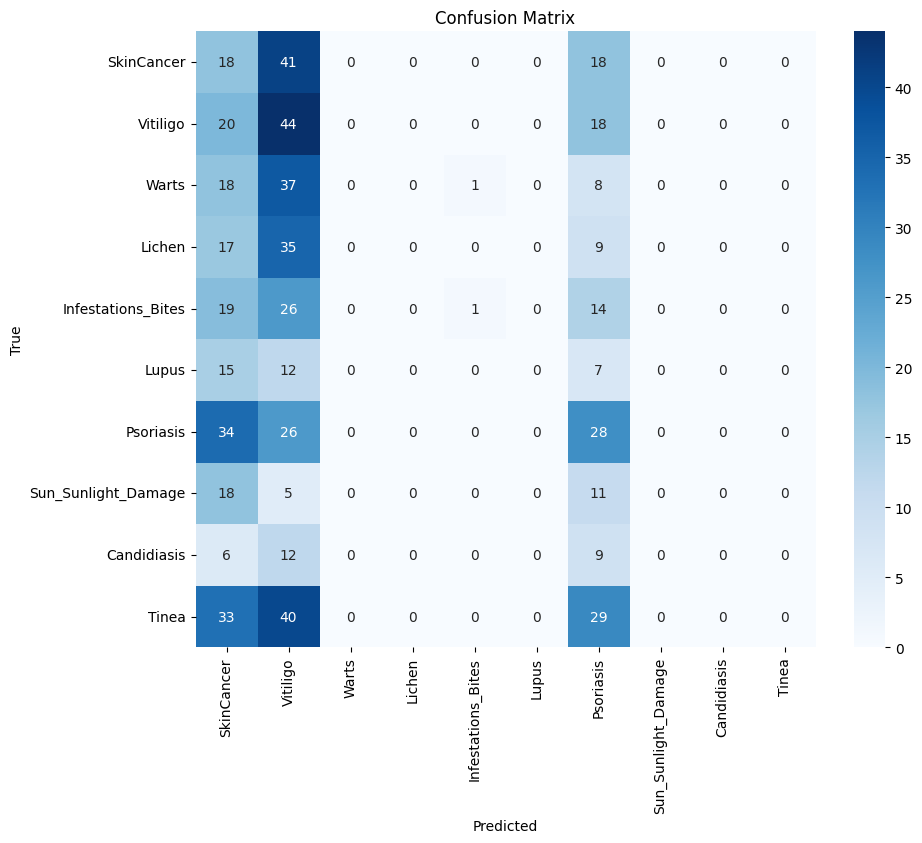

In [20]:
class NoPoolNetwork(nn.Module):
    def __init__(self):
        super(NoPoolNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        #self.pool=nn.MaxPool2d(2, 2)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=NoPoolNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 6, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

In [6]:
class BiggerNetwork(nn.Module):
    def __init__(self):
        super(BiggerNetwork, self).__init__()
        self.fc1=nn.LazyLinear(8192)
        self.fc2=nn.LazyLinear(2048)
        self.fc3=nn.LazyLinear(512)
        self.fc4=nn.LazyLinear(10)
        self.conv1=nn.Conv2d(3, 16, 3)
        self.activation=nn.Tanh()

    def forward(self, x):
        x=self.activation(self.conv1(x))
        x=x.view(x.size(0), -1)
        x=self.fc1(x)
        x=self.fc2(self.activation(x))
        x=self.fc3(self.activation(x))
        x=self.fc4(self.activation(x))
        return x

seed_everything(0)
torch.cuda.empty_cache()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=BiggerNetwork().to(DEVICE)
runNN(model, DEVICE, os.path.join("resources", "resources", "SkinDisease(10 clases)"), 6, 16, torch.optim.Adam(model.parameters(), lr=1), torch.nn.CrossEntropyLoss(), transforms.Compose([transforms.ToPILImage(), transforms.Resize((41, 43)), transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))

[Epoch 1] train_loss: 1200.741 | train_acc: 11.37% | dev_loss: 2168.007 | dev_acc: 6.21%
[Epoch 2] train_loss: 994.522 | train_acc: 10.31% | dev_loss: 479.279 | dev_acc: 10.40%
[Epoch 3] train_loss: 711.296 | train_acc: 11.00% | dev_loss: 920.529 | dev_acc: 7.72%
[Epoch 4] train_loss: 862.467 | train_acc: 11.85% | dev_loss: 774.332 | dev_acc: 8.89%
[Epoch 5] train_loss: 1191.681 | train_acc: 11.59% | dev_loss: 1324.420 | dev_acc: 8.56%


KeyboardInterrupt: 

In [17]:
torch.cuda.empty_cache()
gc.collect()

0